## Initialize the GPU

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
!nvidia-smi

Sat Jan  3 16:50:47 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.51.03              Driver Version: 575.51.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070        Off |   00000000:17:00.0 Off |                  N/A |
| 45%   50C    P2             43W /  270W |    7614MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
from datetime import datetime
from glob import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

# custom code imports
from includes.utils import getPretrainedFromName, addYoloLayers, YoloDecoder
from includes.datagenerator import HyrarchicalDatagenerator


## Load the clickpoints databases
the data is annotated in clickpoint

https://clickpoints.readthedocs.io/en/latest/

https://github.com/fabrylab/clickpoints

In [4]:
FWB_cdbs = sorted(glob("data/*.cdb"))

In [5]:
FWB_cdbs

['data/1029_P4340824.cdb',
 'data/1101_P4380830.cdb',
 'data/1103_P4410861.cdb',
 'data/1104_P4430464.cdb',
 'data/1105_P4440555.cdb',
 'data/1106_P4460536.cdb',
 'data/1114_P4580025.cdb',
 'data/1118_P4600909.cdb',
 'data/1119_P4620133.cdb',
 'data/1122_P4650092.cdb',
 'data/1123_P4650952.cdb',
 'data/1125_P4680104.cdb',
 'data/1127_P4710020.cdb',
 'data/1128_P4720602.cdb',
 'data/1130_P4750356.cdb',
 'data/1201_P4770116.cdb',
 'data/1202_P4780689.cdb',
 'data/1203_P4800296.cdb',
 'data/1208_P4850080.cdb',
 'data/1214_P4890924.cdb',
 'data/1215_P4900296.cdb',
 'data/1216_P4910597.cdb',
 'data/1217_P4920357.cdb',
 'data/1222_P4930656.cdb',
 'data/1224_P4960020.cdb',
 'data/P4360159.cdb',
 'data/P4370812.cdb',
 'data/P4400309.cdb',
 'data/P4480014.cdb',
 'data/P4490007.cdb',
 'data/P4500867.cdb',
 'data/P4520351.cdb',
 'data/P4530518.cdb',
 'data/P4550147.cdb',
 'data/P4560519.cdb',
 'data/P4590524.cdb',
 'data/P4600445.cdb',
 'data/P4600539.cdb',
 'data/P4630136.cdb',
 'data/P4640141.c

In [6]:
# Total number of files
n_files = len(FWB_cdbs)
all_ids = np.arange(n_files)

# Shuffle them randomly
np.random.seed(42)  # Keep this for reproducibility, remove for true random
np.random.shuffle(all_ids)

# Calculate split index (e.g. 80%)
split_idx = int(n_files * 0.8)

# Create the arrays
FWB_training_ids = np.sort(all_ids[:split_idx])
FWB_test_ids = np.sort(all_ids[split_idx:])

print(f"Training IDs ({len(FWB_training_ids)}): {FWB_training_ids}")
print(f"Test IDs ({len(FWB_test_ids)}): {FWB_test_ids}")

Training IDs (42): [ 0  1  2  3  4  5  6  8  9 11 12 13 15 16 17 19 21 23 24 25 26 27 29 30
 31 32 33 34 35 36 37 39 40 41 43 44 45 46 47 48 49 50]
Test IDs (11): [ 7 10 14 18 20 22 28 38 42 51 52]


In [7]:
#used for the provided model.h5
#comment if you want truely random

FWB_training_ids = np.array([0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52])
FWB_test_ids = np.array([8, 9, 16, 22, 32, 34, 35, 45])



In [8]:
downsamples = [64, 32, 16,]

generator_kwargs = dict(
    markers=[
             'Elephant seal',
             'Skua',
             'Giant Petrel',
             'Male',
             'Penguin',
             'Female',
             'Pup',
             'Bird',
             'Fur seal',
             'Sheathbill',
             'Leopard seal',
             'Blond pup',
             'Kelp gull',
             'Field researchers',
            ],
     typeHierarchy = {
    "Seal": {
        "Fur seal": {
            "Male": {},
            "Female": {},
            "Pup": {},
            "Blond pup":{},
        },
        "Elephant seal": {},
        "Leopard seal": {},
    },
    "Bird":{
        "Skua":{},
        "Sheathbill":{},
        "Giant Petrel":{},
        "Kelp gull":{},
        
    },
    "Field researchers":{},
    "Penguin":{},
     },
    
     w=128,
     h=128,
     anchorOverlap=0.5,
     downsamples=downsamples,

     keys=["yolo%03d"%d for d in downsamples],
     outputValues=("o", "x", "y", "w", "h", "c"),
     positive_oversample=0.8,
)


In [9]:
dg = HyrarchicalDatagenerator(
    [FWB_cdbs[i] for i in FWB_training_ids],    
    flipX=False,
    photoNoise=0.,
    photoOffset=0.,
    photoGamma=0.,
    photoMinMax=(0, 255),
    scaling=1,
    batch_size=640,
    noAugmentation=False,
    **generator_kwargs,
)

dg_test = HyrarchicalDatagenerator(
    [FWB_cdbs[i] for i in FWB_test_ids], 
    batch_size=12,
    noAugmentation=True,
    **generator_kwargs,
)


X,y = dg_test.__getitem__(1)

# Sample a fixed validation data set
valset = dg.genValSet()
validation_data = dg.getVal(valset)

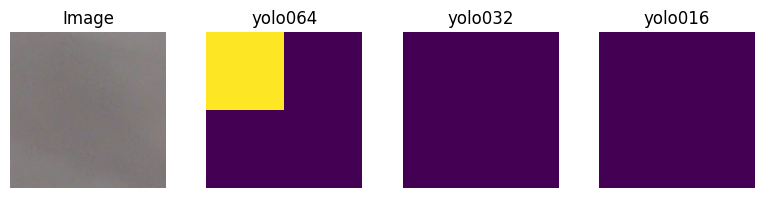

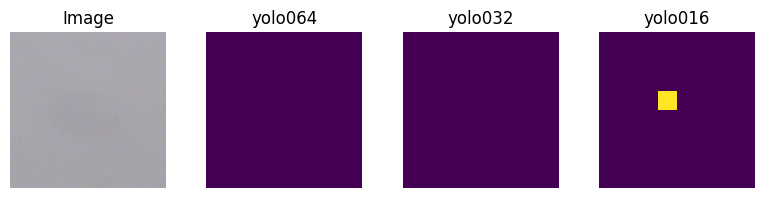

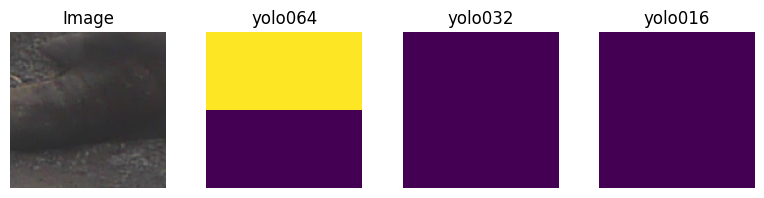

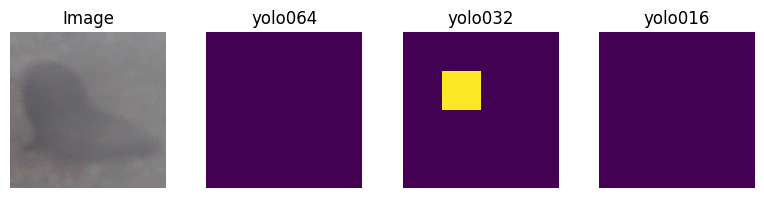

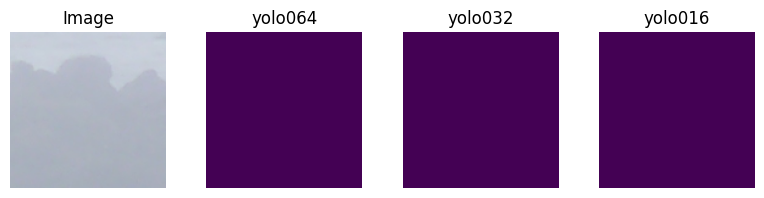

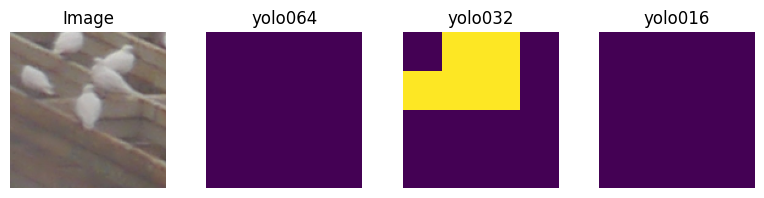

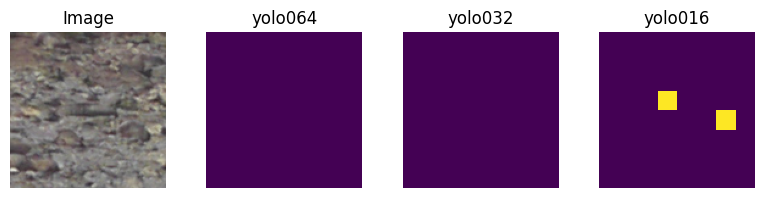

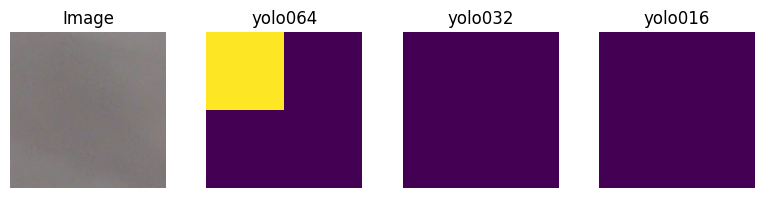

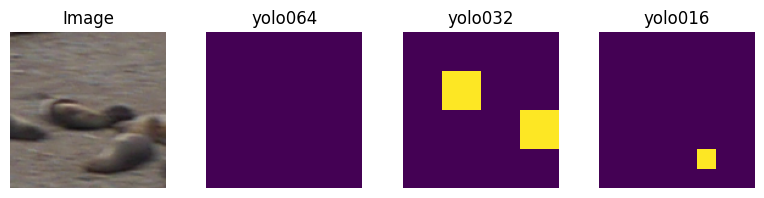

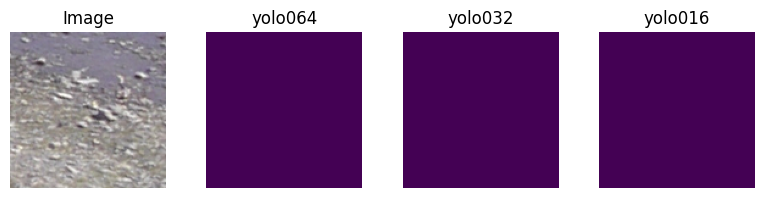

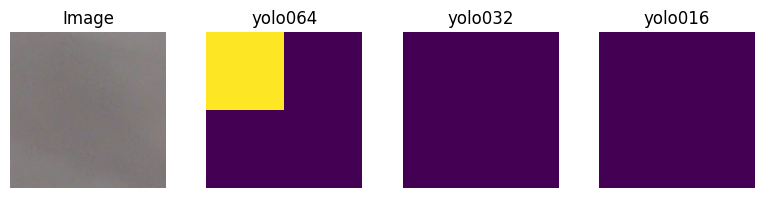

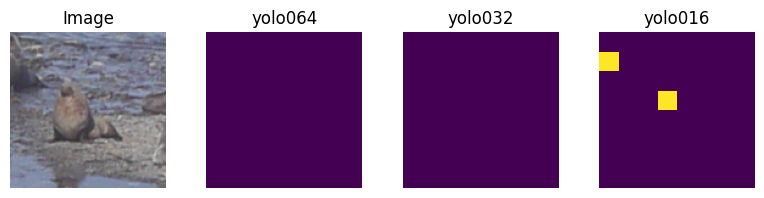

In [10]:
# Make a debug plot to show the output of differnt YOLO layers

# rerun for new random sample
X,y = dg_test.__getitem__(0)

for i in range(dg_test.batch_size):
    fig, axes = plt.subplots(1,len(downsamples)+1, figsize=((len(downsamples)+1)*2,2), dpi=100)

    ax = axes[0]
    ax.set_title("Image")
    ax.imshow(X["Image"][i].astype(np.uint8))

    for j,k in enumerate(y):
        ax = axes[j+1]
        ax.set_title(k)
        ax.imshow(y[k][i,...,0])
    for ax in axes:
        ax.axis("off")
        ax.invert_xaxis()
        ax.invert_yaxis()
    fig.tight_layout()

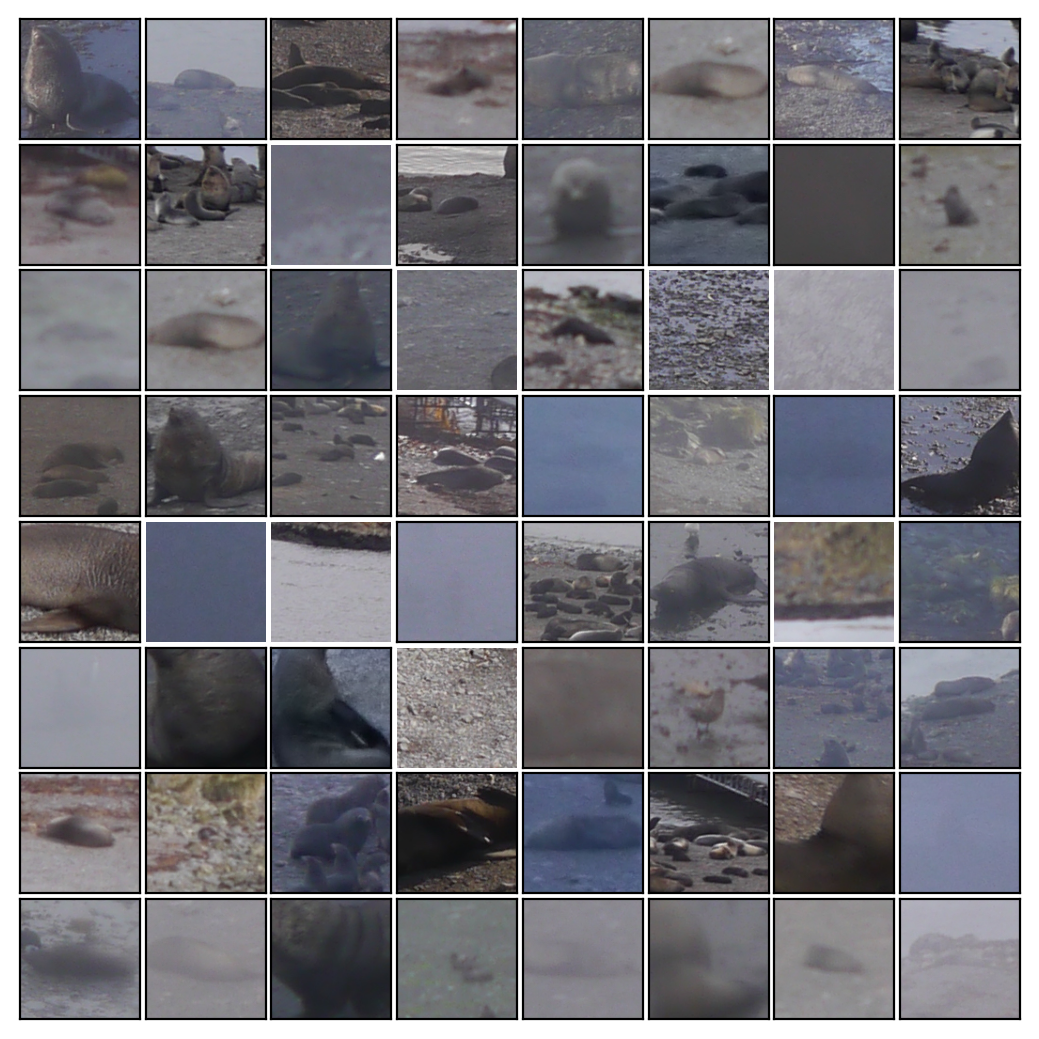

In [11]:
X,y = dg.__getitem__(0)

fig, axes = plt.subplots(8,8, figsize=(5,5), dpi=200)

for i, ax in enumerate(axes.flatten()):
    ax.imshow(X["Image"][i].astype("uint8"))
    if any([l[i,...,0].max() for l in y.values()]):
        ax.set_xticks([])
        ax.set_yticks([])
        #[v.set_color("g") for v in ax.spines.values()]
    else:
        ax.axis("off")
    ax.set_aspect("auto", "box")
    ax.invert_xaxis()
    ax.invert_yaxis()
    
fig.subplots_adjust(bottom=0, top=1, left=0, right=1, hspace=0.05, wspace=0.05)

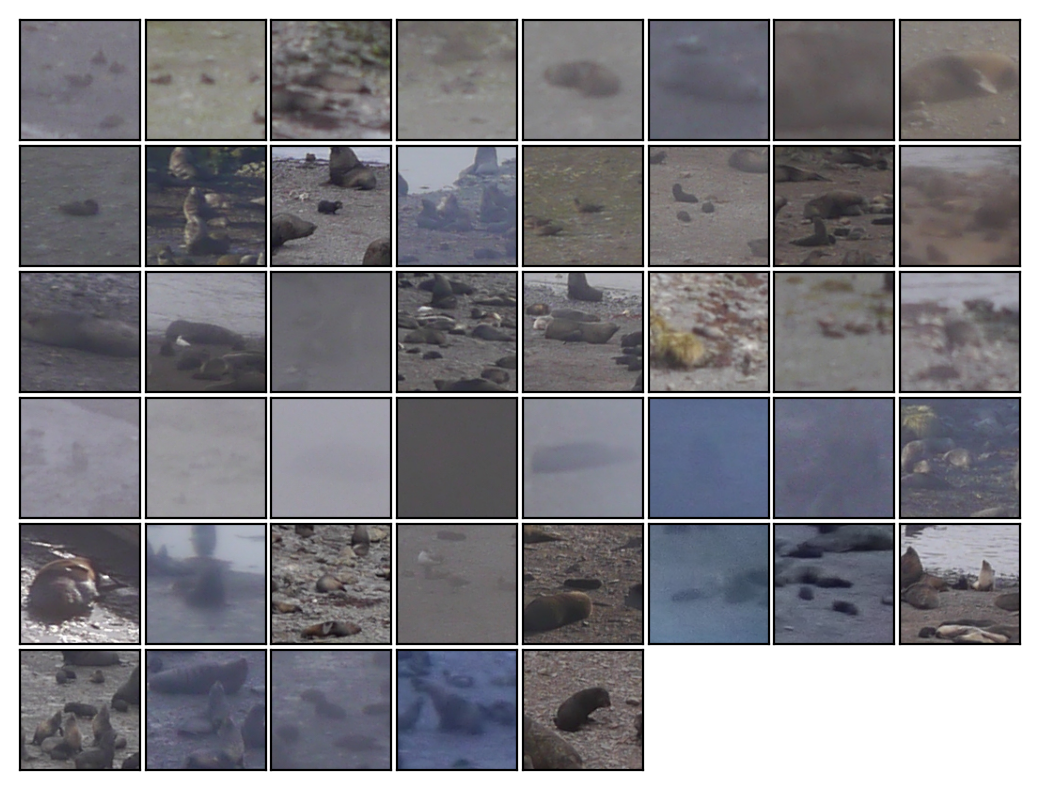

In [12]:
X,y = validation_data

N = X["Image"].shape[0]
a = int(np.floor(N**0.5))
b = int(np.ceil(N/a))
fig, axes = plt.subplots(a,b, figsize=(5*b/8,5*a/8), dpi=200)

for i, ax in enumerate(axes.flatten()):
    if i<N:
        ax.imshow(X["Image"][i].astype("uint8"))
    if i<N and any([l[i,...,0].max() for l in y.values()]):
        ax.set_xticks([])
        ax.set_yticks([])
        #[v.set_color("g") for v in ax.spines.values()]
    else:
        ax.axis("off")
    ax.set_aspect("auto", "box")
    ax.invert_xaxis()
    ax.invert_yaxis()
    
fig.subplots_adjust(bottom=0, top=1, left=0, right=1, hspace=0.05, wspace=0.05)

## Define custom Hierarchy Loss

In [13]:
    
# Custom loss class for hierarchical YOLO
class YoloLossOrigHyrarchical(tf.keras.losses.Loss):
    def __init__(self, *args, coord_scale=5.0, no_object_scale=0.2, outputValues=("o","x","y","w","h","c"),
                 projectTime=True, crop=0, isActivated=False, outputIndizes=None, nClasses=None,
                 levelVectorDict={},
                 **kwargs):
        super(YoloLossOrigHyrarchical, self).__init__(*args, name=type(self).__name__, **kwargs)
        self.outputValues=outputValues
        self.projectTime=projectTime
        self.crop=crop
        self.coord_scale=coord_scale
        self.no_object_scale=no_object_scale
        self.isActivated = isActivated
        self.decoder = YoloDecoder(outputValues=self.outputValues, projectTime=self.projectTime, crop=self.crop,
                                   isActivated=self.isActivated, outputIndizes=outputIndizes, nClasses=nClasses)
        self.nLevels = len(levelVectorDict)
        self.levelMasks = tf.convert_to_tensor(np.array(list(levelVectorDict.values()), dtype="float32"))
        
    def call(self, y_true, y_pred):
        # decoder converts true and predicted labels into class, position x/y, width/height, and class (vector) entries
        # c = true objects, c_ = predicted objects etc.
        (c,c_), (x,x_),(y,y_), (w,w_), (h,h_), (p,p_) = self.decoder.decode(y_true, y_pred)
        
        coord_scale = self.coord_scale
        no_object_scale = self.no_object_scale
        one_obj = c
        no_obj = 1-c
        
        # YOLO loss function
        # L2 distance loss
        xyLoss = coord_scale*tf.reduce_sum(one_obj*((x-x_)**2+(y-y_)**2), axis=(1,2))
        # square root loss for box size
        whLoss = coord_scale*tf.reduce_sum(one_obj*((w**0.5-w_**0.5)**2+(h**0.5-h_**0.5)**2), axis=(1,2))
        # L2 loss for object probability (where there is an object)
        objLoss = tf.reduce_sum(one_obj*(c-c_)**2, axis=(1,2))
        # L2 loss for object probability (apply class inbalance scaling where there is NO object)
        noobjLoss = no_object_scale*tf.reduce_sum(no_obj*(c-c_)**2, axis=(1,2))
        # custom hierarchical class loss 
        # First einsum: "levelMasks" (size LxC) projects the C (number of classes) size true label class vector
        # into an L (number of levels) size level vector. If the true labels contain an entry in one level 
        # the corresponding mask entry will be 1, else 0.
        # Second einsum: "levelMasks" distributes the entries of the C size class loss vector (square of p - p_)
        # into an L x C matrix where only the classes corresponding to a certain level are non-zero.
        # The rest is a dot product of the L size mask and LxC loss matrix projecting the loss of all classes to
        # only the levels present int the true label and summing over all entries.
        m = self.levelMasks
        classLoss = tf.reduce_sum(tf.einsum("lc,bxyc->bxyl",m, p) * tf.einsum("lc,bxyc->bxyl",m, (p-p_)**2), axis=(1,2,-1))[...,None]
        # summarize all loss terms (as in YOLO).
        out=0.
        out += xyLoss
        out += whLoss
        out += objLoss
        out += noobjLoss
        out += classLoss
        return out[:,None,None]

class IOUSLoss(tf.keras.losses.Loss):
    def __init__(self, *args, outputValues=("o","x","y","w","h","c"),
                 projectTime=True, crop=0, isActivated=False, outputIndizes=None, nClasses=None,
                 levelVectorDict={},
                 **kwargs):
        super(IOUSLoss, self).__init__(*args, name=type(self).__name__, **kwargs)
        self.outputValues=outputValues
        self.projectTime=projectTime
        self.crop=crop
        self.isActivated=isActivated
        self.decoder = YoloDecoder(outputValues=self.outputValues, projectTime=self.projectTime, crop=self.crop,
                                   isActivated=self.isActivated, outputIndizes=outputIndizes, nClasses=nClasses)
    def call(self, y_true, y_pred):
        (c,c_), (posx_true,posx_pred),(posy_true,posy_pred), (posw_true,posw_pred), (posh_true,posh_pred), (p,p_) = self.decoder.decode(y_true, y_pred)

        left = tf.maximum(posx_true-posw_true/2, posx_pred-posw_pred/2)
        right = tf.minimum(posx_true+posw_true/2, posx_pred+posw_pred/2)
        bottom = tf.maximum(posy_true-posh_true/2, posy_pred-posh_pred/2)
        top = tf.minimum(posy_true+posh_true/2, posy_pred+posh_pred/2)
        width = tf.maximum(tf.zeros_like(left), right-left)
        height = tf.maximum(tf.zeros_like(bottom), top-bottom)
        I = width*height
        U = tf.maximum(tf.ones_like(I)*tf.keras.backend.epsilon(), (posw_true*posh_true)+(posw_pred*posh_pred)-I)
        bboxLoss = 1-I/U
        return bboxLoss[c>0.5]

class ObjectLoss(tf.keras.losses.Loss):
    def __init__(self, *args, outputValues=("o","x","y","w","h","c"),
                 projectTime=True, crop=0, isActivated=False, outputIndizes=None, nClasses=None,
                 levelVectorDict={},
                 **kwargs):
        super(ObjectLoss, self).__init__(*args, name=type(self).__name__, **kwargs)
        self.outputValues=outputValues
        self.projectTime=projectTime
        self.crop=crop
        self.isActivated = isActivated
        self.decoder = YoloDecoder(outputValues=self.outputValues, projectTime=self.projectTime, crop=self.crop,
                                   isActivated=self.isActivated, outputIndizes=outputIndizes, nClasses=nClasses)
    def call(self, y_true, y_pred):
        (c,c_), (x,x_),(y,y_), (w,w_), (h,h_), (p,p_) = self.decoder.decode(y_true, y_pred)
        c_ += tf.keras.backend.epsilon()
        objectLoss = tf.keras.losses.binary_crossentropy(tf.expand_dims(c,-1), tf.expand_dims(c_,-1)) if "o" in self.outputValues else 0.
        return objectLoss

## Init Network

In [14]:
# Create the network (efficientnetb7 base + custom YOLO header)
netName = "efficientnetb7"

input_tensor = tf.keras.Input((dg.h, dg.w, 3), name="Image",)
net = getPretrainedFromName(netName=netName, input_tensor=input_tensor)

activations = {
    0:"sigmoid",
    1:"sigmoid",
    2:"sigmoid",
    3:"exponential",
    4:"exponential",
    5:"sigmoid",
}

yolos = addYoloLayers(net, downsamples, dg.outputLength, netType="skipConv", yoloName="yolo",activations=None)
model = tf.keras.Model(inputs=net.input, outputs=yolos.values())
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['Image[0][0]']                  
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 129, 129, 3)  0           ['normalization[0][0]']      

 block5d_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5d_se_reduce[0][0]']      
                                                                                                  
 block5d_se_excite (Multiply)   (None, 8, 8, 1344)   0           ['block5d_activation[0][0]',     
                                                                  'block5d_se_expand[0][0]']      
                                                                                                  
 block5d_project_conv (Conv2D)  (None, 8, 8, 224)    301056      ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 8, 8, 224)   896         ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_d

 yolo032 (Concatenate)          (None, 4, 4, 20)     0           ['yolo032_filter0[0][0]',        
                                                                  'yolo032_filter1[0][0]',        
                                                                  'yolo032_filter2[0][0]',        
                                                                  'yolo032_filter3[0][0]',        
                                                                  'yolo032_filter4[0][0]',        
                                                                  'yolo032_filter5[0][0]',        
                                                                  'yolo032_filter6[0][0]',        
                                                                  'yolo032_filter7[0][0]',        
                                                                  'yolo032_filter8[0][0]',        
                                                                  'yolo032_filter9[0][0]',        
          

In [15]:
loss_kwargs = dict(outputValues=dg.outputValues, projectTime=False, isActivated=False,
                       outputIndizes=dg.outputIndizes, nClasses=len(dg.markers),
                   levelVectorDict=dg.levelVectorDict,
                  )

loss = dict([[v, YoloLossOrigHyrarchical(**loss_kwargs)] for v in dg.keys])
metrics = dict([[v, {
    "IOU": IOUSLoss(**loss_kwargs),
    "Object": ObjectLoss(**loss_kwargs),
}] for v in dg.keys])

## Training the model

In [12]:
# transfer learning step
lr = 1e-4
epochs=3
net.trainable = False
dg.batch_size = 32
dg.X = np.zeros((dg.batch_size, dg.h, dg.w, 1, 3), dtype=np.float32)

model.compile(loss=loss, metrics=metrics, optimizer=Adam(lr=lr),)
checkpoint = tf.keras.callbacks.ModelCheckpoint(datetime.now().strftime("results/%Y%m%d-%H%M%S_yolo_transfer.h5"),
                                                monitor='val_loss', verbose=1,
                                                save_best_only=True,
                                                save_weights_only=True, mode='min')
callbacks = [checkpoint]
history = model.fit(dg, epochs=epochs, validation_data=validation_data, callbacks=callbacks)

Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 30.0848 - yolo064_loss: 4.9781 - yolo032_loss: 4.2666 - yolo016_loss: 20.8401 - yolo064_IOUSLoss: 0.7584 - yolo064_ObjectLoss: 0.8378 - yolo032_IOUSLoss: 0.8336 - yolo032_ObjectLoss: 1.1926 - yolo016_IOUSLoss: 0.9008 - yolo016_ObjectLoss: 0.8350
Epoch 00001: val_loss improved from inf to 87.49831, saving model to results/20260103-142358_yolo_transfer.h5
1/1 [==============================] - 30s 30s/step - loss: 30.0848 - yolo064_loss: 4.9781 - yolo032_loss: 4.2666 - yolo016_loss: 20.8401 - yolo064_IOUSLoss: 0.7584 - yolo064_ObjectLoss: 0.8378 - yolo032_IOUSLoss: 0.8336 - yolo032_ObjectLoss: 1.1926 - yolo016_IOUSLoss: 0.9008 - yolo016_ObjectLoss: 0.8350 - val_loss: 87.4983 - val_yolo064_loss: 1.8401 - val_yolo032_loss: 55.9069 - val_yolo016_loss: 29.7514 - val_yolo064_IOUSLoss: 0.4809 - val_yolo064_ObjectLoss: 0.7752 - val_yolo032_IOUSLoss: 0.8578 - val_yolo032_ObjectLoss: 1.0991 - val_yolo016_IOUSLoss: 0.8772 - val_yolo0

In [ ]:
lr = 1e-5
epochs=1 #1000 we are running in this notebook just one to test the code
dg.batch_size = 10
dg.X = np.zeros((dg.batch_size, dg.h, dg.w, 1, 3), dtype=np.float32)
net.trainable = True
model.compile(loss=loss, metrics=metrics, optimizer=Adam(lr=lr),)
checkpoint = tf.keras.callbacks.ModelCheckpoint(datetime.now().strftime("results/%Y%m%d-%H%M%S_yolo.h5"),
                                                monitor='val_loss', verbose=1,
                                                save_best_only=True,
                                                save_weights_only=True, mode='min')

callbacks = [checkpoint]
model.fit(dg, epochs=epochs, validation_data=validation_data, callbacks=callbacks)

## Loading the trained model or our provided weights

In [16]:
model_file = "model.h5"
model.load_weights(model_file)

## Evaluate model

In [17]:
from tqdm import tqdm

Coder = YoloDecoder(**loss_kwargs)
true_c, false_c, true_i, false_i = [],[],[],[],


test_data = []
for image_id, (H,W,_) in dg_test.imageShape.items():
    for x in range(0, W, dg_test.w):
        for y in range(0, H, dg_test.h):
            test_data.append([image_id, x, y])

for j in tqdm(range(len(test_data)//dg_test.batch_size)):
    bigGrid = dict(
        [[dg_test.keys[j], np.zeros((dg_test.batch_size, ASX, ASY, dg_test.nOutputs), dtype=np.float32)] for j, (ASX, ASY) in
         enumerate(dg_test.downsamplesN)])
    dg_test.X[:] = 0
    for b in range(dg_test.batch_size):
        image_id, pos_x, pos_y = test_data[j*dg_test.batch_size + b]

        imSlice, grid = dg_test.__getSample__(image_id=image_id, pos_X=pos_x, pos_Y=pos_y)
        dg_test.X[b] = imSlice[:,:,None,:]
        for k in bigGrid:
            bigGrid[k][b] = grid[k][0]
    X, y = {"Image": dg_test.X[:,:,:,0,:]}, dict([[k, v[:,:,:,:]] for k,v in bigGrid.items()])
    
#for j in tqdm(range(int(np.ceil(1024/dg_test.batch_size)))):
#    X,y = dg_test.__getitem__(0)
    y_pred = model.predict(X)

    CC = []
    CC_ = []
    XYWH = []
    XYWH_ = []
    P = []
    P_ = []
    for j,k in enumerate(y.keys()):
        ds = dg.downsamples[j]
        dX,dY = dg.downsamplesN[j]
        dXYWH = np.array(np.meshgrid(np.arange(dX)*ds, np.arange(dY)*ds, 0, 0)).squeeze().transpose((1,2,0))[None,...]

        c,*xywh,p = Coder.decodeTrue(y[k], returnNumpy=True)
        xywh = ds*np.concatenate(xywh, axis=-1) + dXYWH
        c_,*xywh_,p_ = Coder.decodePred(y_pred[j], returnNumpy=True)
        xywh_ = ds*np.concatenate(xywh_, axis=-1) + dXYWH

        bs = len(c)
        CC.append(c.reshape((bs, -1, 1)))
        CC_.append(c_.reshape((bs, -1, 1)))
        XYWH.append(xywh.reshape((bs, -1, 4)))
        XYWH_.append(xywh_.reshape((bs, -1, 4)))
        P.append(p.reshape((bs, -1, p.shape[-1])))
        P_.append(p_.reshape((bs, -1, p_.shape[-1])))

    CC = np.concatenate(CC, axis=1)
    CC_ = np.concatenate(CC_, axis=1)
    XYWH = np.concatenate(XYWH, axis=1)
    XYWH_ = np.concatenate(XYWH_, axis=1)
    P = np.concatenate(P, axis=1)
    P_ = np.concatenate(P_, axis=1)

    epsilon = np.finfo(XYWH_.dtype).eps

    left = np.maximum((XYWH_[...,0])[...,None,:], (XYWH_[...,:,0])[...,:,None])
    right = np.minimum((XYWH_[...,0]+XYWH_[...,2])[...,None,:], (XYWH_[...,:,0]+XYWH_[...,2])[...,:,None])
    top = np.maximum((XYWH_[...,1])[...,None,:], (XYWH_[...,:,1])[...,:,None])
    bottom = np.minimum((XYWH_[...,1]+XYWH_[...,3])[...,None,:], (XYWH_[...,:,1]+XYWH_[...,3])[...,:,None])

    width = np.maximum(np.zeros_like(left), right-left)
    height = np.maximum(np.zeros_like(bottom), bottom-top)

    I = width * height
    U = np.maximum(np.ones_like(I)*epsilon, XYWH_[...,None,:,2]*XYWH_[...,None,:,3] + XYWH_[...,:,None,2]*XYWH_[...,:,None,3] - I)
    IOU = I/U * (CC_[...,None,:,0]>CC_[...,:,None,0])
    IOU_max = IOU.max(-1)[...,None]

    m = CC>0.5
    true_c.extend(CC_[m])
    false_c.extend(CC_[~m])
    true_i.extend(IOU_max[m])
    false_i.extend(IOU_max[~m])
true_c = np.array(true_c)
false_c = np.array(false_c)
true_i = np.array(true_i)
false_i = np.array(false_i)


100%|██████████| 648/648 [01:17<00:00,  8.31it/s]


In [18]:
thresholds = np.linspace(0,1,1000)
ious = np.linspace(0,1,100)
thresholdsx = (thresholds[:-1]+thresholds[1:])/2
iousx = (ious[:-1]+ious[1:])/2

tp,*_ = np.histogram2d(true_c, true_i, bins=(thresholds, ious))
fp,*_ = np.histogram2d(false_c, false_i, bins=(thresholds, ious))

tp = np.cumsum(np.cumsum(tp, axis=1)[::-1], axis=0)[::-1]
fp = np.cumsum(np.cumsum(fp, axis=1)[::-1], axis=0)[::-1]
fn = len(true_c)-tp

rec = tp/(tp+fp)
prec = tp/(tp+fn)

f1 = 2/(1/rec+1/prec)
n1 = prec/rec

#fp = np.cumsum(np.cumsum(fp, axis=0), axis=1)

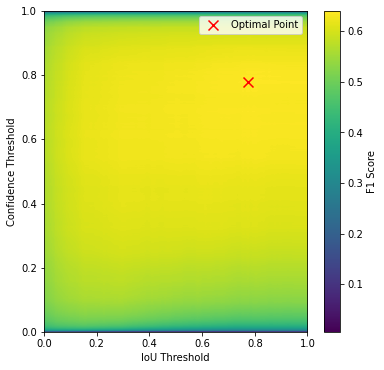

In [19]:
# Find the location of the best F1 score
best_idx = np.unravel_index(np.argmax(f1), f1.shape)
best_conf_idx, best_iou_idx = best_idx

# Get the actual values for the labels
best_conf = thresholdsx[best_idx[0]]
best_iou = iousx[best_idx[1]]
max_f1 = f1[best_idx]

fig,ax = plt.subplots(figsize=(5.9,5.9))
plt.imshow(f1, aspect='auto', origin='lower', extent=[0, 1, 0, 1])

ax.set_xlabel('IoU Threshold')
ax.set_ylabel('Confidence Threshold')
plt.colorbar(label='F1 Score')

plt.scatter(best_iou, best_conf, marker='x', c='red', s=100, label='Optimal Point')
plt.legend()

In [20]:
idC, idI = np.unravel_index(np.nanargmax(f1), f1.shape)
print(thresholdsx[idC], iousx[idI], f1[idC, idI], n1[idC, idI])

0.7802802802802802 0.7727272727272727 0.6399413346370081 0.9370265151515151


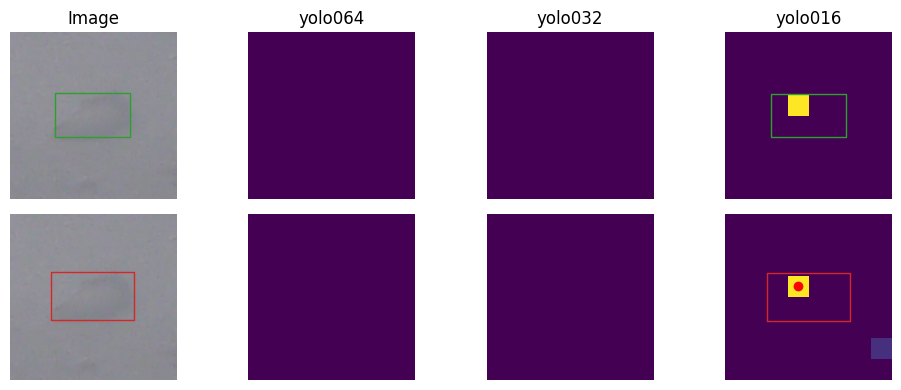

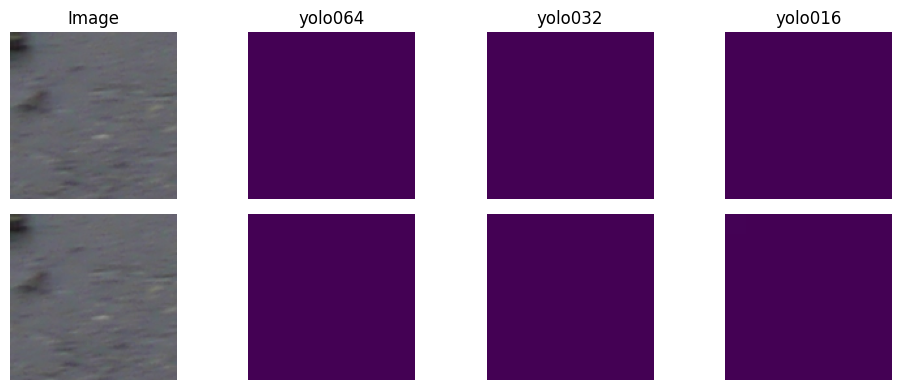

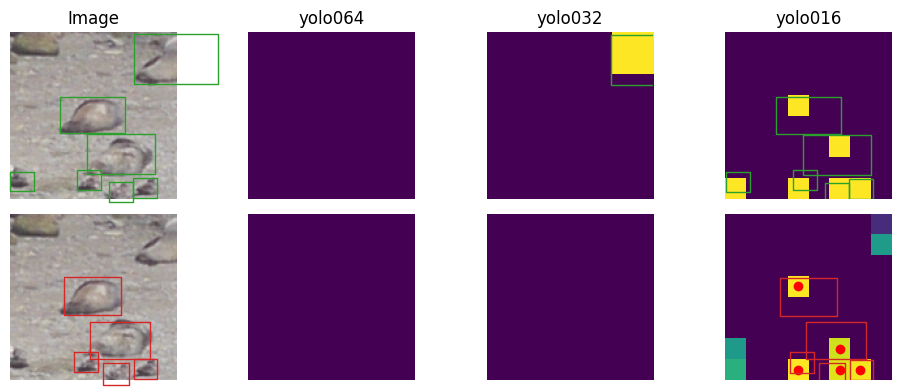

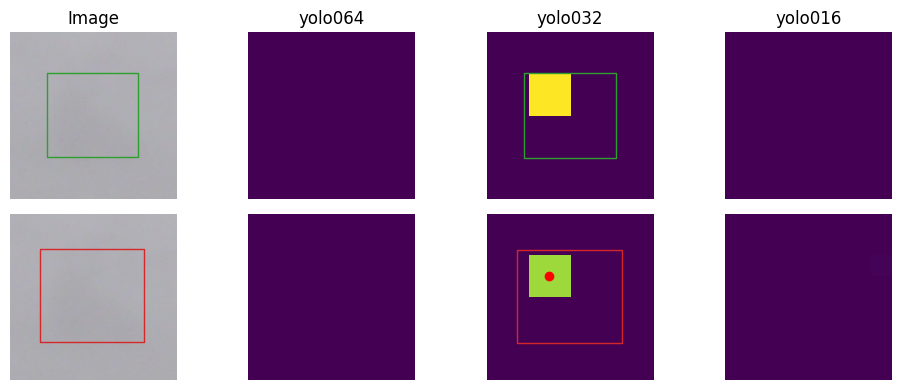

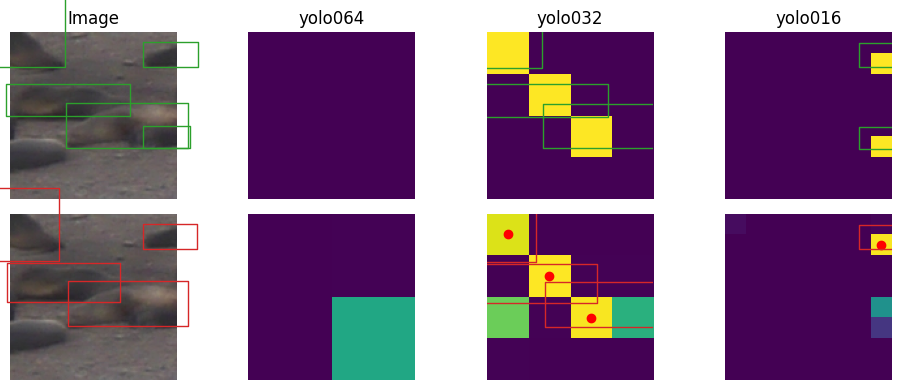

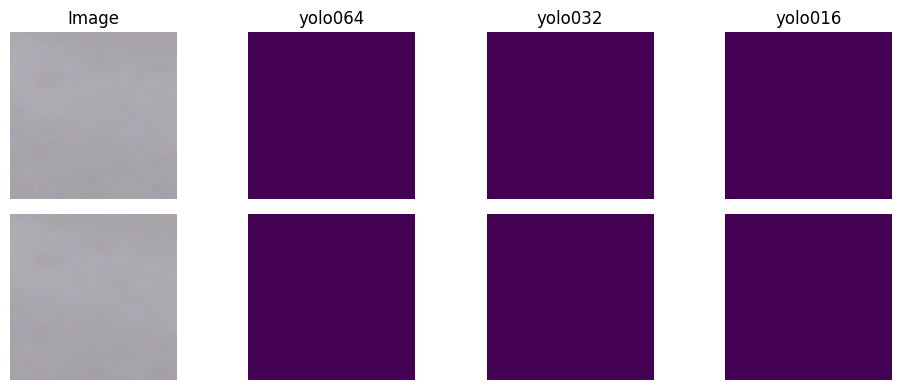

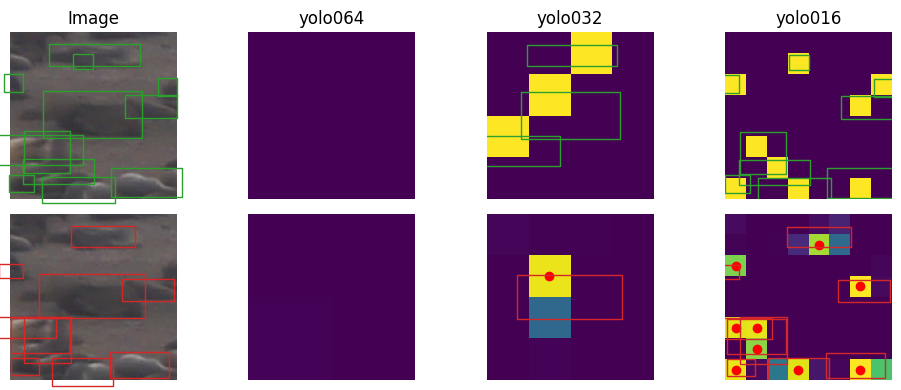

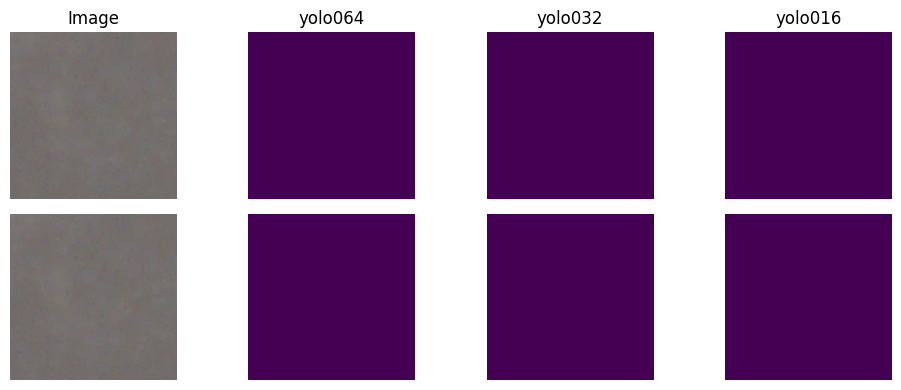

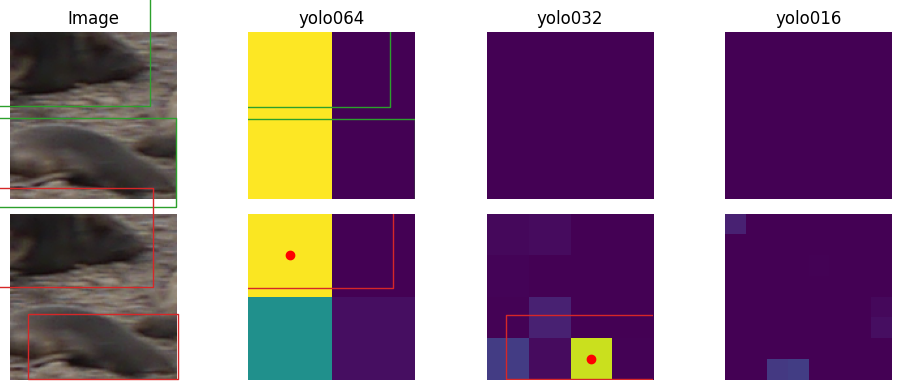

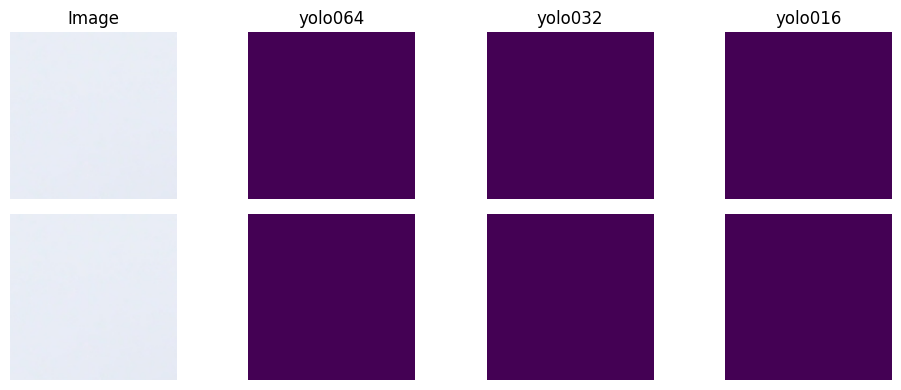

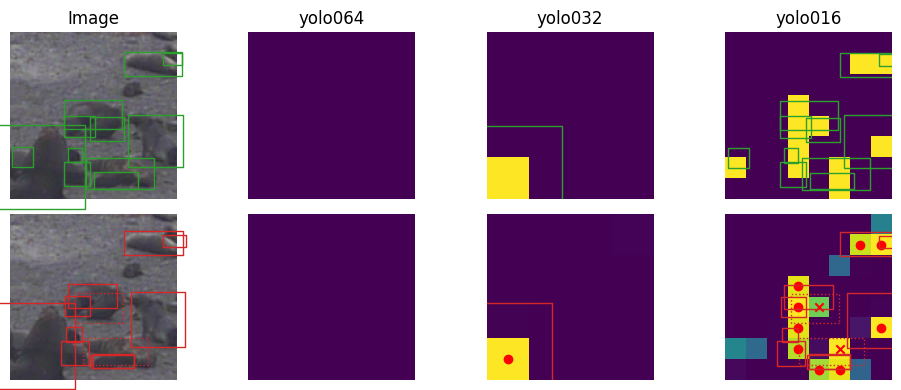

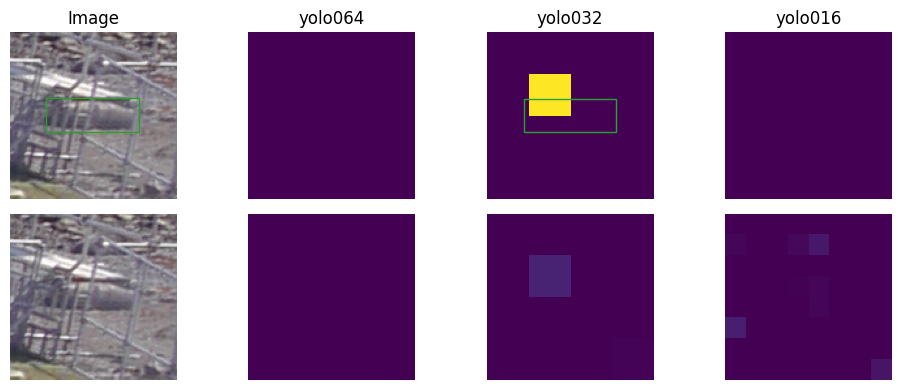

In [25]:
import matplotlib.patches as mPatches
from matplotlib.collections import PatchCollection


IOU_threshold = 1-iousx[idI] #1-0.7424242424242424
threshold = thresholdsx[idC] #0.3938938938938939

X, y = dg_test.__getitem__(0)
bs = dg_test.batch_size
y_pred = model(X)

decoded = dict([[k, np.zeros((dg_test.batch_size, nh, nw, dg_test.outputLength))] for (nh, nw), k in zip(dg_test.downsamplesN, dg_test.keys)])
for i, k in enumerate(dg_test.keys):
    oP, xP, yP, wP, hP, cP = Coder.decodePred(y_pred=y_pred[i])
    decoded[k][:] = np.concatenate([oP, xP, yP, wP, hP, cP], axis=-1)

slopes = np.array([[1,] + 4*[ds,] for ds in dg_test.downsamples])
intercepts = [
    np.array(np.meshgrid(0, ds*np.arange(dX), ds*np.arange(dY), 0, 0)).squeeze().transpose((1,2,0))
for ds, (dX,dY) in zip(dg_test.downsamples, dg_test.downsamplesN)]

oxywh = np.concatenate([(decoded[k][...,:5]*slopes[j]+intercepts[j]).reshape((bs, -1, 5)) for j,k in enumerate(y.keys())], axis=1)

left = np.maximum((oxywh[...,1])[...,None,:], (oxywh[...,1])[...,None])
right = np.minimum((oxywh[...,1]+oxywh[...,3])[...,None,:], (oxywh[...,1]+oxywh[...,3])[...,None])
top = np.maximum((oxywh[...,2])[...,None,:], (oxywh[...,2])[...,None])
bottom = np.minimum((oxywh[...,2]+oxywh[...,4])[...,None,:], (oxywh[...,2]+oxywh[...,4])[...,None])
width = np.maximum(np.zeros_like(left), right-left)
height = np.maximum(np.zeros_like(bottom), bottom-top)
I = width * height
U = np.maximum(np.ones_like(I)*epsilon, oxywh[...,None,:,3]*oxywh[...,None,:,4] + oxywh[...,None,3]*oxywh[...,None,4] - I)
IOU = (I/U)*(oxywh[...,None,:,0]>oxywh[...,None,0])
IOU_max = IOU.max(-1)

ids = np.cumsum([0,] + [dX*dY for dX,dY in dg_test.downsamplesN])
start_ids = ids[:-1]
end_ids = ids[1:]

IOU_max = [IOU_max[:,s:e].reshape((bs,dY,dX)) for s,e,(dX,dY) in zip(start_ids, end_ids, dg_test.downsamplesN)]

for i in range(dg_test.batch_size):
    fig, axes = plt.subplots(2,len(dg_test.downsamples)+1, figsize=(10,4), dpi=100)

    imAx = axes[0,0]
    imAx.set_title("Image")
    imAx.imshow(X["Image"][i].astype(np.uint8))
    imAx2 = axes[1,0]
    imAx2.imshow(X["Image"][i].astype(np.uint8))

    for j,k in enumerate(y):
        ax = axes[0, j+1]
        ax.set_title(k)
        ds = dg_test.downsamples[j]
        vals = y[k][i]
        o = vals[...,0]    
        m = o>0.5
        ax.imshow(o, vmin=0, vmax=1, extent=(0,dg_test.w,dg_test.h,0))    
        
        if m.sum()>0:
            yy,xx = np.where(m)
            #ax.scatter(xx,yy)

            xx = (xx+vals[m,1])*ds
            yy = (yy+vals[m,2])*ds
            ww = ds*vals[m,3]
            hh = ds*vals[m,4]
            ax.add_collection(PatchCollection([
                mPatches.Rectangle((x-w/2,y-h/2),w,h) for x,y,w,h in zip(xx,yy,ww,hh)
            ], fc="none", ec="C2"))
            imAx.add_collection(PatchCollection([
                mPatches.Rectangle((x-w/2,y-h/2),w,h) for x,y,w,h in zip(xx,yy,ww,hh)
            ], fc="none", ec="C2", clip_on=False))
            
        
        
    for j,k in enumerate(y):
        ax = axes[1, j+1]
        ds = dg_test.downsamples[j]
        vals = decoded[k][i]
        iou = IOU_max[j][i]
        o = vals[...,0]    
        ax.imshow(o, vmin=0, vmax=1, extent=(0,dg_test.w,dg_test.h,0))    
        m = o>threshold
        m2 = ((o>threshold)&(iou<IOU_threshold))[m]
        ax.scatter(*(ds*(np.array(np.where((o>threshold)&(iou<IOU_threshold))[::-1])+0.5)), marker="o", color="r")
        ax.scatter(*(ds*(np.array(np.where((o>threshold)&(iou>IOU_threshold))[::-1])+0.5)), marker="x", color="r")
        
        if m.sum()>0:
            yy,xx = np.where(m)
            #ax.scatter(xx,yy)

            xx = (xx+vals[m,1])*ds
            yy = (yy+vals[m,2])*ds
            ww = ds*vals[m,3]
            hh = ds*vals[m,4]
            ax.add_collection(PatchCollection([
                mPatches.Rectangle((x-w/2,y-h/2),w,h) for x,y,w,h in zip(xx,yy,ww,hh)
            ], fc="none", ec="C3", ls=np.array([":","-"])[m2.astype(int)]))
            imAx2.add_collection(PatchCollection([
                mPatches.Rectangle((x-w/2,y-h/2),w,h) for x,y,w,h in zip(xx,yy,ww,hh)
            ], fc="none", ec="C3", clip_on=False,  ls=np.array([":","-"])[m2.astype(int)]))

        #rects = 
        
        
        
    for ax in axes.flatten():
        ax.axis("off")
        ax.invert_xaxis()
        ax.invert_yaxis()
        
    fig.tight_layout()
    #break
    


In [22]:
class classDecoder():
    def __init__(self, levelVectorDict, levelLabels, markers, typeHierarchy, vectorDict):
        self.levelVectorDict = levelVectorDict
        self.levelLabels = levelLabels
        self.markers = markers
        self.typeHierarchy = typeHierarchy
        self.vectorDict = vectorDict
        
        self.vectorDict_matrix = np.array(list(self.vectorDict.values()))
                                          
        levelVectorDict_matrix = np.array(list(self.levelVectorDict.values()))
        levelVectorDict_matrixConst = np.cumsum([0, *np.sum(levelVectorDict_matrix, axis=1)[:-1]])

        levelLabelLengths = np.array([len(v) for v in self.levelLabels.values()])
        codes__ = np.arange(np.prod(levelLabelLengths+1))
        self.codes_A = np.cumprod([1, *(levelLabelLengths[:-1]+1)])
        self.codes_B = (levelLabelLengths+1)
        codes_ = (codes__[:,None]//self.codes_A[None,:])%(self.codes_B[None,:])

        decode_array = []
        long_markers = list(self.markers)
        for code in codes_:
            hy_entry = dict(self.typeHierarchy)
            key = ""
            for i,c in enumerate(code):
                key = [*self.levelLabels[i], key][c-1]
                if key not in long_markers:
                    long_markers.append(key)
                    decode_array.append(long_markers.index(key))
                    break

                if key in hy_entry:
                    hy_entry = hy_entry[key]
                else:
                    decode_array.append(long_markers.index(key))
                    break
            else:
                decode_array.append(self.markers.index(key))
        self.long_markers = long_markers
        self.levelVectorDict_matrixConst = levelVectorDict_matrixConst
        self.levelVectorDict_matrix = levelVectorDict_matrix
        self.decode_array = np.array(decode_array)   
        
        self.eps = np.finfo("float").resolution

    def decode(self, p):
        p2 = np.exp(np.einsum("qp,Nxyp->Nxyq", self.vectorDict_matrix, np.log(p+self.eps)))
        p_id_max = np.maximum(0,
                      np.argmax(np.einsum("Nxyp,lp->Nxypl",
                               p2,
                               self.levelVectorDict_matrix), axis=-2)-self.levelVectorDict_matrixConst)
        p_max = np.max(np.einsum("Nxyp,lp->Nxypl",
                                 p2, self.levelVectorDict_matrix), axis=-2)

        code_pred = np.sum((p_id_max+1) * (p_max>0.5) * self.codes_A, axis=-1)
        return self.decode_array[code_pred]


In [27]:
class_decoder = classDecoder(dg.levelVectorDict, dg.levelLabels, dg.markers, dg.typeHierarchy, dg.vectorDict)

n_classes = len(class_decoder.long_markers)
class_confusion = np.zeros((n_classes+1, n_classes+1), dtype=int)

np.random.seed(1234)
testSet = []
for i in range((10*1024)//len(dg_test.data)):
    testSet.extend(dg_test.genValSet())

for j in tqdm(range(0, len(testSet), 320)):
    X,y = dg_test.getVal(testSet[j:j+320])
    
    y_pred = model.predict(X)

    for i,k in enumerate(y.keys()):
        m_ct = Coder.decodeTrue(y[k], returnNumpy=True)[0][...,0]>0
        m_cp = Coder.decodePred(y_pred[i], returnNumpy=True)[0][...,0]>threshold
        m_TP = m_ct & m_cp
        m_FP = (~m_ct) & m_cp
        m_FN = m_ct & (~m_cp)
        pred_classes = class_decoder.decode(Coder.decodePred(y_pred[i], returnNumpy=True)[-1])
        true_classes = class_decoder.decode(Coder.decodeTrue(y[k], returnNumpy=True)[-1])
        
        #pred X true
        class_confusion[:-1,:-1] += np.bincount(pred_classes[m_TP]*n_classes + true_classes[m_TP],
                                                minlength=n_classes**2).reshape((n_classes,n_classes))
        class_confusion[:-1,-1] += np.bincount(pred_classes[m_FP], minlength=n_classes)
        class_confusion[-1,:-1] += np.bincount(true_classes[m_FN], minlength=n_classes)
        

100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


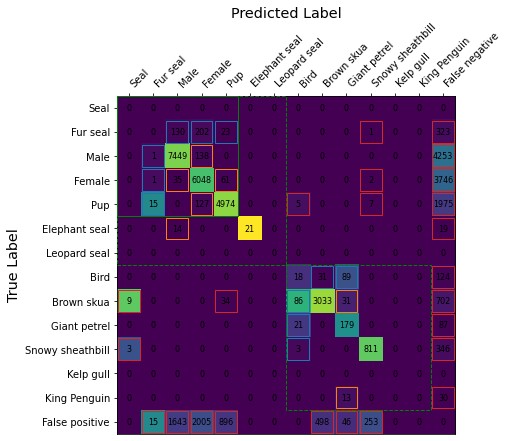

In [63]:
import matplotlib.patches as mpatches

new_label_order = [
    'Seal',
    'Fur seal',
    'Male',
    'Female',
    'Pup',
    'Elephant seal',
    'Leopard seal',
    'Bird',
    'Skua',
    'Giant Petrel',
    'Sheathbill',
    'Kelp gull',
    'Penguin',
]

#label_order = np.array([13, 8, 3, 5, 6, 11, 0, 10, 7, 1, 2, 9, 4, 12, 14])
label_order = np.array([class_decoder.long_markers.index(l) for l in new_label_order] + [n_classes,])

labels_ordered_y = [(class_decoder.long_markers + ["false positive",]) [i] for i in label_order] 
labels_ordered_x = [(class_decoder.long_markers + ["false negative",]) [i] for i in label_order] 
vals = np.array(class_confusion)
fig, ax = plt.subplots(figsize=(7,7))

vals_ordered = vals[label_order,:][:, label_order].T
with np.errstate(divide='ignore', invalid='ignore'): # Silence divide by zero warnings
    norm_vals = vals_ordered / vals_ordered.sum(0)

# Replace NaNs (caused by dividing by zero) with 0
norm_vals = np.nan_to_num(norm_vals)

# Now plot the safe matrix
ax.imshow(norm_vals)

for i in np.arange(vals_ordered.shape[0]):
    for j in np.arange(vals_ordered.shape[1]):
        ax.text(i,j, "%d"%vals_ordered[j,i], va="center", ha="center",fontsize=8)

ax.tick_params(axis="both", which="both", top=True, labeltop=True, bottom=False, labelbottom=False)
# Define how you want to rename the labels
label_renaming = {
    'Skua': 'Brown skua',
    'Seals': 'Seal',
    'Giant Petrel': 'Giant petrel',
    'Sheathbill': 'Snowy sheathbill',
    'Kelp gull': 'Kelp gull',
    'Penguin': 'King Penguin',
    'false positive' : 'False positive',
    'false negative' : 'False negative',
}

# Create new lists of display labels
display_labels_x = [label_renaming.get(l, l) for l in labels_ordered_x]
display_labels_y = [label_renaming.get(l, l) for l in labels_ordered_y]

ax.set_xticks(np.arange(len(display_labels_x)), minor=False)
# Use display_labels_x instead of labels_ordered_x
ax.set_xticklabels(display_labels_x, ha="left", minor=False) 
ax.tick_params(axis="x", which="major", rotation=45)

ax.set_yticks(np.arange(len(display_labels_y)))
# Use display_labels_y instead of labels_ordered_y
ax.set_yticklabels(display_labels_y)
#
ax.add_artist(mpatches.Rectangle((-0.5,-0.5), 5,5, facecolor="none", edgecolor="g", zorder=5))
ax.add_artist(mpatches.Rectangle((-0.5,-0.5), 7,7, facecolor="none", edgecolor="g", ls="--", zorder=5))
ax.add_artist(mpatches.Rectangle((6.5,6.5), 6,6, facecolor="none", edgecolor="g",ls="--", zorder=5))
for y,x in zip(*np.where(vals_ordered>0)):
    if x==y:
        continue
    elif all([v in ['Seal', 'Fur seal','Male','Female','Pup','Blond pup','Elephant seal','Leopard seal',] for v in (labels_ordered_x[x], labels_ordered_y[y])]):
        
        # Define lists for cleaner checking
        all_seals = ['Fur seal','Male','Female','Pup','Blond pup','Elephant seal','Leopard seal']
        fur_seal_subtypes = ['Male','Female','Pup','Blond pup']
        
        if any([
            # --- EXISTING: Truth is Generic, Pred is Specific ---
            labels_ordered_y[y]=='Seal' and labels_ordered_x[x] in all_seals,
            labels_ordered_y[y]=='Fur seal' and labels_ordered_x[x] in fur_seal_subtypes,
            labels_ordered_y[y]=='Pup' and labels_ordered_x[x] == 'Blond pup',
            
            # --- NEW: Pred is Generic, Truth is Specific (The Reverse) ---
            labels_ordered_x[x]=='Seal' and labels_ordered_y[y] in all_seals,
            labels_ordered_x[x]=='Fur seal' and labels_ordered_y[y] in fur_seal_subtypes,
            labels_ordered_x[x]=='Pup' and labels_ordered_y[y] == 'Blond pup',
        ]):
            color="C0" # Blue (Hierarchical error)
        else:
            color="C1" # Orange (Sibling error)
    elif all([v in ['Bird', 'Skua', 'Giant Petrel', 'Sheathbill', 'Kelp gull',"Penguin"] for v in (labels_ordered_x[x], labels_ordered_y[y])]):
        
        bird_subtypes = ['Skua', 'Giant Petrel', 'Sheathbill', 'Kelp gull', "Penguin"]

        if any([
            # --- EXISTING: Truth is Generic, Pred is Specific ---
            labels_ordered_y[y]=='Bird' and labels_ordered_x[x] in bird_subtypes,

            # --- NEW: Pred is Generic, Truth is Specific ---
            labels_ordered_x[x]=='Bird' and labels_ordered_y[y] in bird_subtypes,
        ]):
            color="C0" # Blue
        else:
            color="C1" # Orange
    else:
        color="C3"
    ax.add_artist(mpatches.Rectangle((x-0.45,y-0.45), 0.9,0.9, facecolor="none", edgecolor=color))
#ax.add_artist(mpatches.Rectangle((8.5,3.5), 1,1, facecolor="none", edgecolor="r"))

ax.set_ylabel("True Label", fontsize="x-large")
ax.set_xlabel("Predicted Label", fontsize="x-large")
ax.xaxis.set_label_position('top') 
plt.tight_layout()
# plt.savefig("matrix.png",dpi=200,figsize=(5.9,5.9))

In [64]:
f1s = {}
for ids, group_name,  in [
    (np.arange(len(vals_ordered)-1), "Global"),
    (np.arange(0,6), "Seals"),
    (np.arange(1,4), "Fur seals"),
    *enumerate(labels_ordered_x[:-1])
]:
    if isinstance(ids, int):
        ids = np.array([ids])
    not_ids = np.array(list(set(np.arange(len(vals_ordered))).difference(ids)), dtype=int)
    gTP = vals_ordered[ids][:, ids].sum()
    gFP = vals_ordered[ids][:, not_ids].sum()
    gFN = vals_ordered[not_ids][:, ids].sum()
    gTN = vals_ordered[not_ids][:, not_ids].sum()
    gRec = np.nanmax([0, gTP/(gTP+gFN)])
    gPrec = np.nanmax([0, gTP/(gTP+gFP)])
    gF1 = 2/(1/gRec + 1/gPrec)
    print(group_name, "F1=%.2f"%np.round(gF1,2))
    f1s[group_name] = gF1


Global F1=0.74
Seals F1=0.72
Fur seals F1=0.70
Seal F1=0.00
Fur seal F1=0.00
Male F1=0.71
Female F1=0.66
Pup F1=0.76
Elephant seal F1=0.56
Leopard seal F1=0.00
Bird F1=0.09
Skua F1=0.81
Giant Petrel F1=0.56
Sheathbill F1=0.73
Kelp gull F1=0.00
Penguin F1=0.00


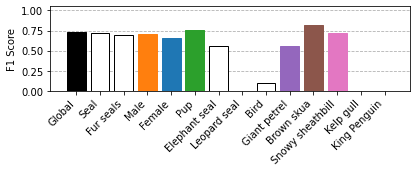

In [33]:
colors = {
    "Global": "black",
    'Female': '#1F77B4',
    'Male': '#FF7F0E',
    'Pup': '#2CA02C',
    'Giant Petrel': '#9467bd', # purple
    'Skua': '#8C564B',         # brown
    'Sheathbill': '#e377c2',   # pink
}

ordered_keys = ["Global", "Seals", "Fur seals"] + list(labels_ordered_x[:-1])

# 3. Extract data in order
plot_keys = ["Global","Seals","Fur seals","Male","Female","Pup","Elephant seal","Leopard seal","Bird","Giant Petrel","Skua","Sheathbill", "Kelp gull","Penguin"]
plot_vals = [f1s[k] for k in plot_keys]
# Create display labels: use renamed version if available, else original
plot_labels = [label_renaming.get(k, k) for k in plot_keys]

# 4. Plot
fig, ax = plt.subplots(figsize=(5.9, 2.5))
bars = ax.bar(plot_keys, plot_vals) # Plot using original keys to map bars easily

# 5. Apply Styling
for bar, key in zip(bars, plot_keys):
    if key in colors:
        bar.set_color(colors[key])
        # Colored bars have no outline by default
    else:
        # The "rest" get white face with black outline
        bar.set_facecolor('white')
        bar.set_edgecolor('black')
        bar.set_linewidth(1)

# 6. Final Formatting
ax.set_ylabel("F1 Score")
ax.set_ylim(0, 1.05)
ax.set_xticks(np.arange(len(plot_labels)))
ax.set_xticklabels(plot_labels, rotation=45, ha='right')

# Add a light grid for readability (optional)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.yaxis.grid(True, linestyle='--', alpha=1)
# ax.axhline(y=f1s["Global"],zorder=0,color="black",alpha=0.6)
ax.set_axisbelow(True)

plt.tight_layout()
# plt.savefig("f1_scores_bar.png", dpi=200)